## Analysis of ReAct and LLM-DP Alfworld data

In [93]:
import json

output_dir = "output"
dataset = []

file_to_name = {
    "output/chat_random_3.json": "llmdp-random",
    "output/chat_search2_3.json": "llmdp",
    "output/react_chat.json": "react-chat",
    "output/react_text-davinci-002.json": "react-002",
}
order = [
    "llmdp",
    "llmdp-random",
    "react-002",
    "react-chat",
]

for file in file_to_name.keys():
    with open(file, "rb") as f:
        d = json.loads(f.read())
        for i, example in enumerate(d):
            example["file"] = file
            example["n"] = i
        dataset.extend(d)

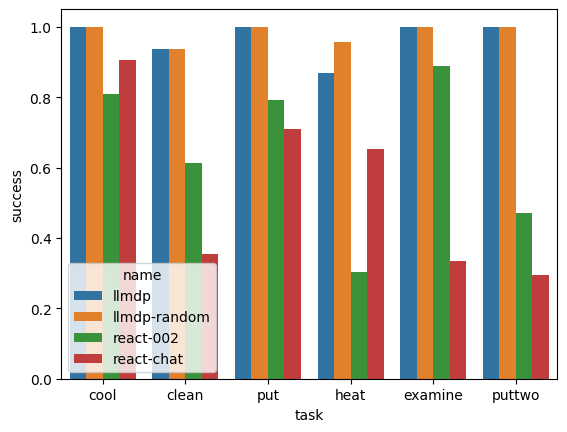

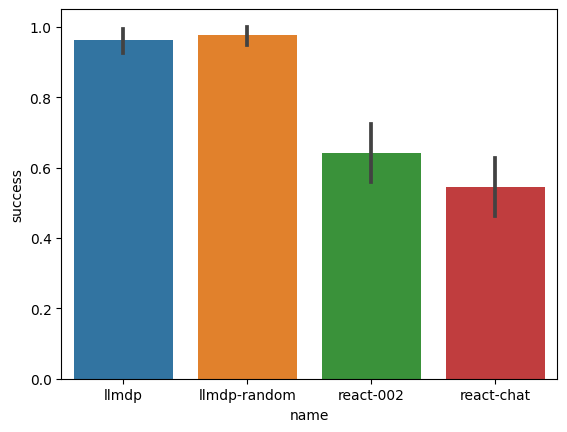

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(dataset)
df["success"] = df["success"].astype(int)
df["name"] = df["file"].apply(lambda x: file_to_name[x])


sns.barplot(x="task", y="success", hue="name", hue_order=order,
              data=df, errwidth=0)
plt.show()

sns.barplot(y="success", x="name", order=order,
            data=df)
plt.show()

In [110]:
# Latex table
tmp = df.groupby(["name", "task"]).success.agg(["mean"])
# rotate index
tmp = tmp.unstack().swaplevel(axis=1).sort_index(axis=1, level=0)
tmp.columns = tmp.columns.droplevel(1)
tmp = tmp.reset_index(drop=False)
tmp.name = tmp.name.apply(lambda x: "\\texttt{" + x + "}")

cols =  ["clean", "cool", "examine", "heat", "put", "puttwo"]
tmp["overall"] = df.groupby(["name"]).success.agg(["mean"]).reset_index(drop=False)["mean"]
# format to % all columns except name
tmp = tmp.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)
# tmp.columns = ["name"] + [f"{n} (\%)" for n in tmp.columns if n != "name"] 
print(tmp.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llllllll}
\toprule
name & clean & cool & examine & heat & put & puttwo & overall \\
\midrule
\texttt{llmdp} & 0.94 & 1.00 & 1.00 & 0.87 & 1.00 & 1.00 & 0.96 \\
\texttt{llmdp-random} & 0.94 & 1.00 & 1.00 & 0.96 & 1.00 & 1.00 & 0.98 \\
\texttt{react-002} & 0.61 & 0.81 & 0.89 & 0.30 & 0.79 & 0.47 & 0.64 \\
\texttt{react-chat} & 0.35 & 0.90 & 0.33 & 0.65 & 0.71 & 0.29 & 0.54 \\
\bottomrule
\end{tabular}



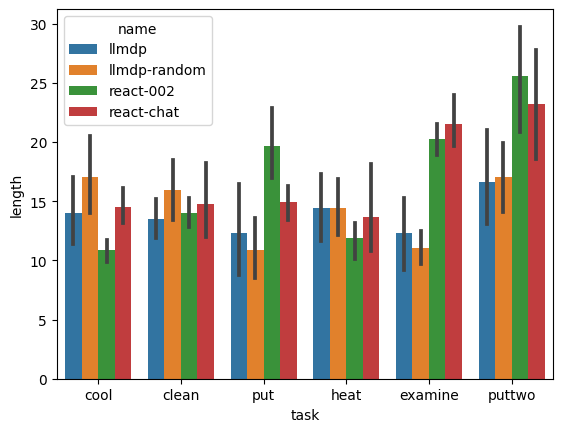

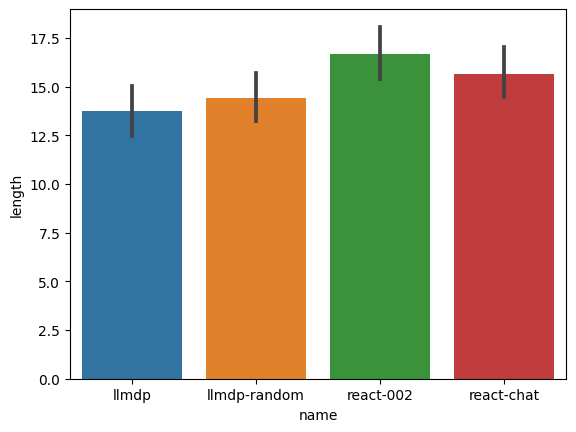

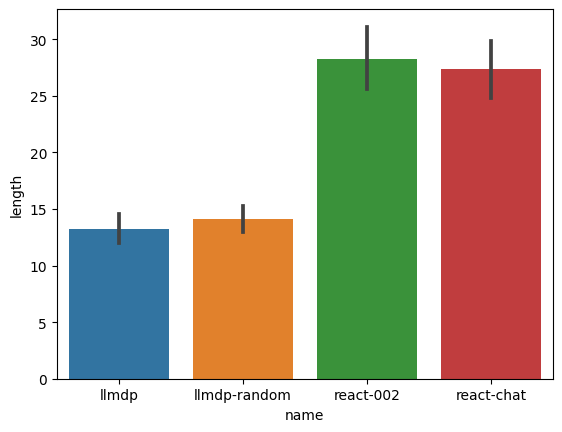

In [99]:
sns.barplot(x="task", y="length", hue="name", data=df[df.success == 1], hue_order=order)
plt.show()

sns.barplot(y="length", x="name", order=order,
              data=df[df.success == 1])
plt.show()
sns.barplot(y="length", x="name", order=order,
              data=df)
plt.show()

In [105]:
# Latex table
tmp = df.groupby(["name", "task"]).length.agg(["mean"])
# rotate index
tmp = tmp.unstack().swaplevel(axis=1).sort_index(axis=1, level=0)
tmp.columns = tmp.columns.droplevel(1)
tmp = tmp.reset_index(drop=False)
tmp.name = tmp.name.apply(lambda x: "\\texttt{" + x + "}")

cols =  ["clean", "cool", "examine", "heat", "put", "puttwo"]
tmp["overall"] = df.groupby(["name"]).length.agg(["mean"]).reset_index(drop=False)["mean"]
# format to % all columns except name
tmp = tmp.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)
tmp.columns = ["name"] + [f"{n}" for n in tmp.columns if n != "name"] 
print(tmp.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llllllll}
\toprule
name & clean & cool & examine & heat & put & puttwo & overall \\
\midrule
\texttt{llmdp} & 12.68 & 14.00 & 12.28 & 12.65 & 12.33 & 16.65 & 13.27 \\
\texttt{llmdp-random} & 14.94 & 17.05 & 11.06 & 13.78 & 10.88 & 17.06 & 14.09 \\
\texttt{react-002} & 27.55 & 18.14 & 23.44 & 37.70 & 25.75 & 38.00 & 28.27 \\
\texttt{react-chat} & 34.68 & 14.81 & 34.89 & 22.70 & 22.00 & 35.65 & 27.39 \\
\bottomrule
\end{tabular}



0    13.268657
1    14.089552
2    28.268657
3    27.388060
Name: mean, dtype: float64

### Estimating Token Counts (cost)

In [87]:
import tiktoken
from collections import defaultdict

encoding = tiktoken.encoding_for_model("text-davinci-002")

min_token_count = defaultdict(int)
with open("prompts/alfworld_react.json", "r") as file:
    prompts = json.loads(file.read())
    for k, v in prompts.items():
       if k.startswith("react"):
          min_token_count[k.split("_")[1]] += len(encoding.encode(v))

print(min_token_count)

df.loc[df.name == "react-002", "llm_tokens"] = df[df.name == "react-002"].apply(lambda x: x["length"]*min_token_count[x["task"]], axis=1)

defaultdict(<class 'int'>, {'put': 934, 'clean': 1407, 'heat': 1122, 'cool': 1323, 'puttwo': 1333, 'examine': 1297})


In [88]:
# df["llm_chat_tokens"].fillna(0, inplace=True)

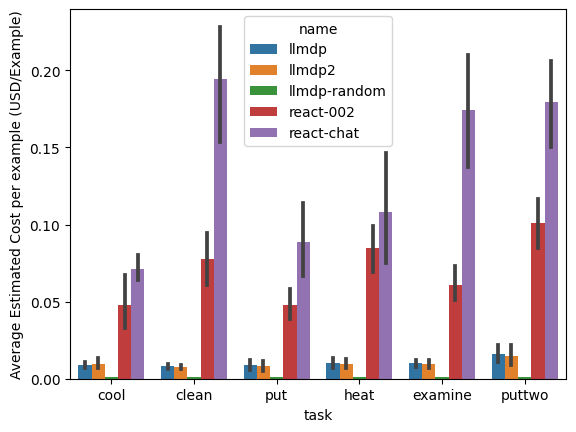

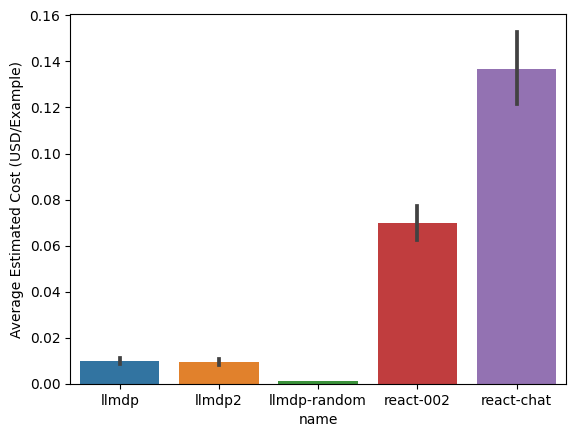

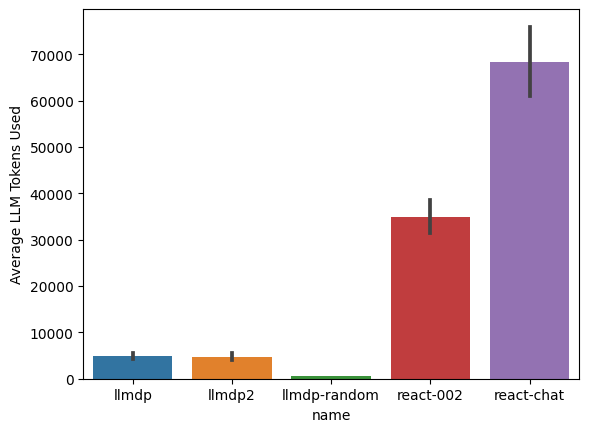

In [89]:
# DAVINCI_TOKEN_COST = 0.0200/1000
CHAT_TOKEN_COST = 0.002/1000
df["cost"] = df["llm_tokens"]*CHAT_TOKEN_COST # + df["llm_chat_tokens"]*CHAT_TOKEN_COST

sns.barplot(x="task", y="cost", hue="name", data=df, hue_order=order)
plt.ylabel("Average Estimated Cost per example (USD/Example)")
plt.show()

sns.barplot(y="cost", 
            x="name",
            data=df,
            order=order)
plt.ylabel("Average Estimated Cost (USD/Example)")
plt.show()

sns.barplot(y="llm_tokens", 
            x="name",
            data=df,
            order=order            
            )
plt.ylabel("Average LLM Tokens Used")
plt.show()

           name       cost
0         llmdp   1.321422
1  llmdp-random   0.134184
2        llmdp2   1.266814
3     react-002   9.328158
4    react-chat  18.321254


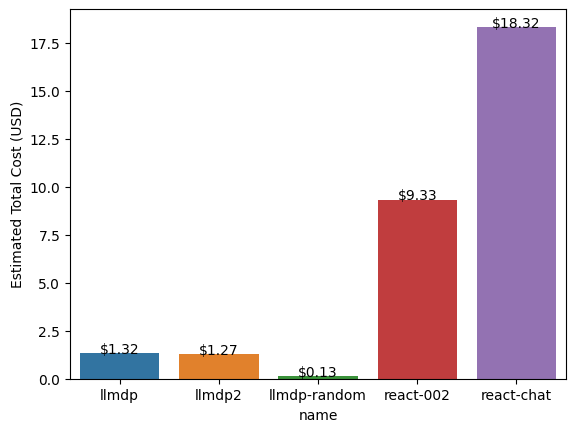

In [90]:
# aggregate cost per name and then plot
new_df = df.groupby("name").sum()["cost"]
new_df = new_df.reset_index()
print(new_df)
sns.barplot(y="cost",
            x="name",
            data=new_df,
            order=order)

plt.ylabel("Estimated Total Cost (USD)")

# add numerical label on top of chart
for i, name in enumerate(order):
    c = new_df[new_df.name == name].iloc[0].cost.round(2)
    plt.text(i, c, f"${c}", color='black', ha="center")
plt.show()

In [91]:
# generate latex table
tmp = df.groupby("name").agg(davinci_tokens=("llm_tokens", "sum"), chat_tokens=("llm_chat_tokens", "sum"), total_cost=("cost", "sum"), avg_cost=("cost", "mean")).round(2).reset_index(drop=False)
tmp.name = tmp.name.apply(lambda x: "\\texttt{" + x + "}")
print(tmp.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
name & davinci_tokens & chat_tokens & total_cost & avg_cost \\
\midrule
\texttt{llmdp} & 660711.00 & 0.00 & 1.32 & 0.01 \\
\texttt{llmdp-random} & 67092.00 & 0.00 & 0.13 & 0.00 \\
\texttt{llmdp2} & 633407.00 & 0.00 & 1.27 & 0.01 \\
\texttt{react-002} & 4664079.00 & 0.00 & 9.33 & 0.07 \\
\texttt{react-chat} & 9160627.00 & 0.00 & 18.32 & 0.14 \\
\bottomrule
\end{tabular}



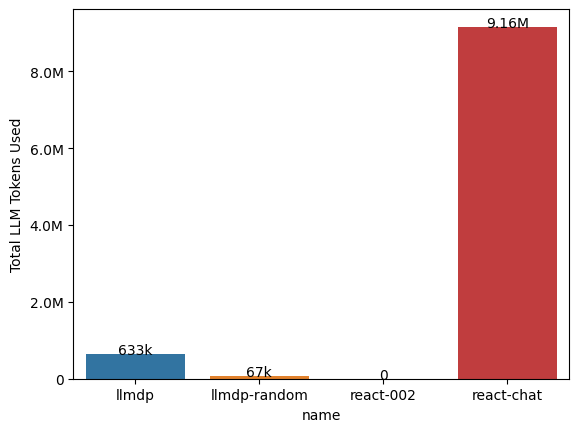

,name,llm_tokens
0,llmdp,633407.0
1,llmdp-random,67092.0
2,react-002,0.0
3,react-chat,9160627.0


In [98]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_y_ticks(value, _):

    if value >= 1_000_000:
        r = (value % 1_000_000)/10000
        return f"{int(value/1_000_000)}.{int(r)}M"
    elif value >= 1_000:
        return f"{int(value/1_000)}k"
    else:
        return int(value)
    
# chart: sum of tokens
sns.barplot(y="llm_tokens", 
            x="name",
            estimator=sum,
            data=df.groupby("name").sum()["llm_tokens"].reset_index(),
            order=order
            )
plt.ylabel("Total LLM Tokens Used")

new_df = df.groupby("name").sum()["llm_tokens"].reset_index()
for i, name in enumerate(order):
    y = new_df[new_df.name == name].iloc[0].llm_tokens
    c = format_y_ticks(y, None)
    plt.text(i, y, f"{c}", color='black', ha="center")
# plt.show()


ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
plt.show()

df.groupby("name").sum()["llm_tokens"].reset_index()

# .to_latex(index=False, float_format="%.2f")